In [15]:
from pathlib import Path

import torch
from torch.utils.data import Dataset
from sklearn.metrics import accuracy_score, ConfusionMatrixDisplay

import matplotlib.pyplot as plt

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
cpu = torch.device("cpu")
print(f"Using device: {device}")

Using device: cuda


In [16]:
# force to reload the internal modules
import sys
sys.modules.pop('data', None)
sys.modules.pop('mlp_classifier', None)
sys.modules.pop('cnn_classifier', None)

import data
import mlp_classifier
import cnn_classifier

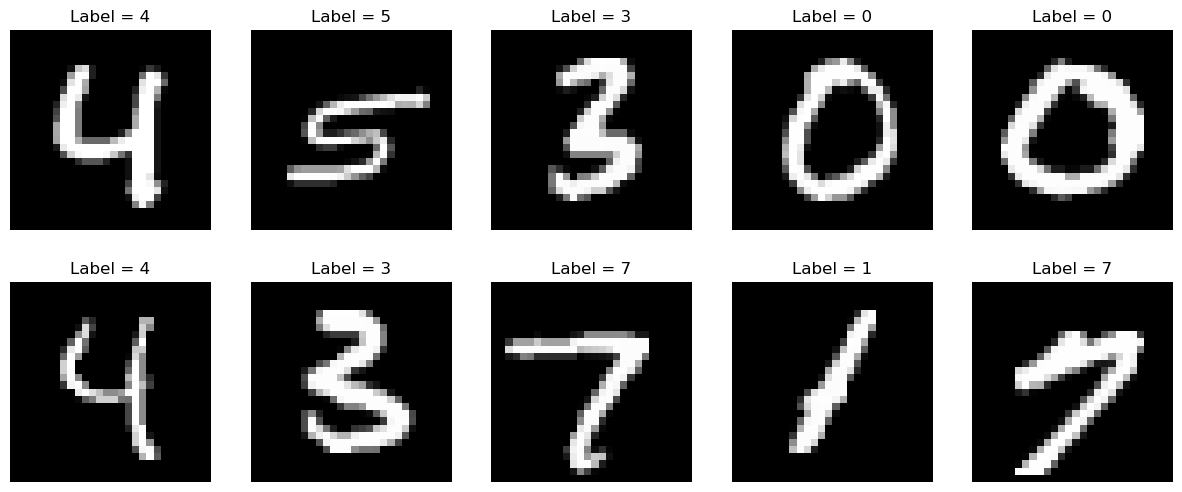

In [17]:
# --- Extract data from local files

n = 10000
data_path = Path('.', 'MNIST')

x_train, y_train = data.get_train_data(data_path, n)
x_test, y_test = data.get_test_data(data_path, n)
x_train_img = x_train.reshape(n, 1, 28, 28)
x_test_img = x_test.reshape(n, 1, 28, 28)

data.show_sample(x_train_img, y_train, 10)

In [18]:
# --- Standardize the data

x_mean, x_std = x_train.mean(), x_train.std()

x_train = (x_train - x_mean) / x_std
x_train_img = (x_train_img - x_mean) / x_std

x_test = (x_test - x_mean) / x_std
x_test_img = (x_test_img - x_mean) / x_std

In [19]:
# --- Create the model

# model = mlp_classifier.FullyConnectedClassifier()
model = cnn_classifier.ConvolutionalClassifier()
print(f"The model has {sum(p.numel() for p in model.parameters())} parameters")

The model has 44426 parameters


accuracy = 0.095


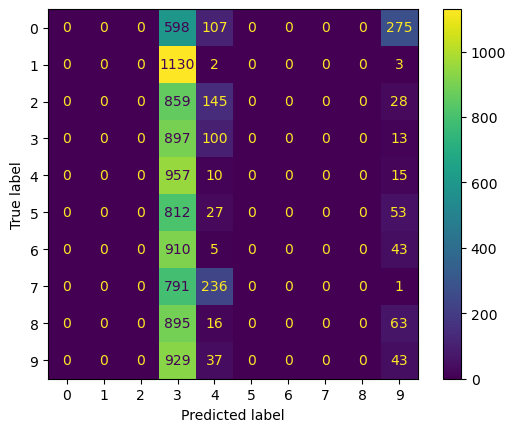

In [20]:
# --- Test the model before training

with torch.no_grad():
    # y_test_pred = model.predict(x_test)
    y_test_pred = model.predict(x_test_img)

accuracy = accuracy_score(y_test, y_test_pred)
print(f"{accuracy = }")

ConfusionMatrixDisplay.from_predictions(y_test, y_test_pred)

Training on device: cuda
[epoch 0] epoch loss = 2.2921
[epoch 10] epoch loss = 0.1810
[epoch 20] epoch loss = 0.0888
[epoch 30] epoch loss = 0.0543
[epoch 40] epoch loss = 0.0354
[epoch 50] epoch loss = 0.0219
[epoch 60] epoch loss = 0.0137
[epoch 70] epoch loss = 0.0069
[epoch 80] epoch loss = 0.0042
[epoch 90] epoch loss = 0.0027


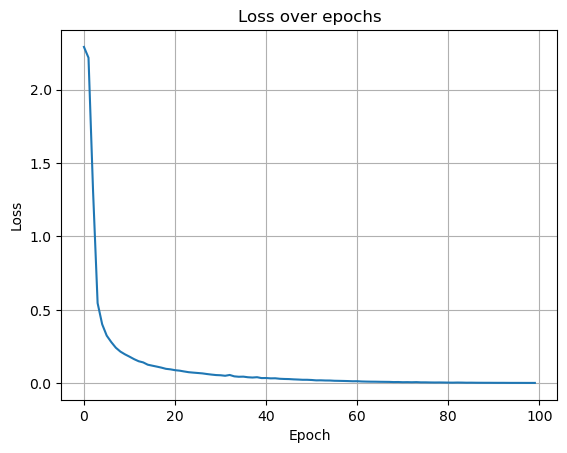

In [ ]:
# --- Train the model

class TrainData(Dataset):
    def __init__(self, x_train, y_train):
        assert x_train.size(0) == y_train.size(0)
        self.x_train = x_train
        self.y_train = y_train

    def __len__(self):
        return self.x_train.size(0)

    def __getitem__(self, idx):
        return self.x_train[idx], self.y_train[idx]


model.to(device)
epoch_values, loss_values = model.training_loop(
    device=device,
    # train_data=TrainData(x_train, y_train),
    train_data=TrainData(x_train_img, y_train),
    nb_epochs=100,
    batch_size=64,
    learning_rate=0.01
)
model.to(cpu)


plt.title("Loss over epochs")
plt.plot(epoch_values, loss_values)
plt.grid()
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.show()

accuracy = 0.977


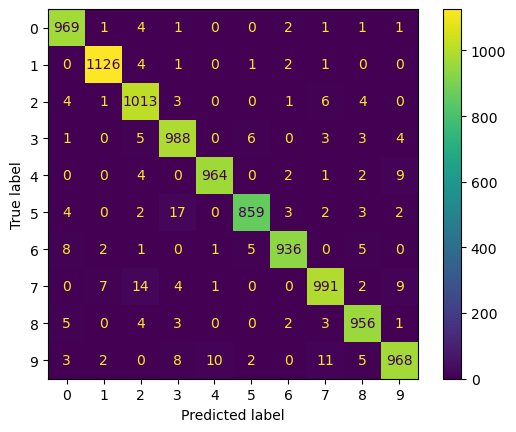

In [22]:
# --- Test the model after training

with torch.no_grad():
    # y_test_pred = model.predict(x_test)
    y_test_pred = model.predict(x_test_img)

accuracy = accuracy_score(y_test, y_test_pred)
print(f"{accuracy = }")

ConfusionMatrixDisplay.from_predictions(y_test, y_test_pred)